# Experiments with learning rates: cyclical, 1cycle, fixed, range test


**Tags: learning rate, learning rate range test, cyclical learning rate, one-cycle policy, 
transfer learning,    
binary classification of IDC in breast cancer histological images**

Date created: May 20, 2018   
Last modified: Oct 5, 2018 

The learning rate (LR) is the most important tuning parameter in a deep learning system. The usual procedure when training a model is to monotonically decrease the learning rate by applying a decay schedule or function. Experiments to understand the behavior of stochastic gradient descent near convergence, have shown that by cycling the learning rate between reasonable bounds, the model reaches convergence an order of magnitude faster <a href="#ref1">[1]</a>. One reason for this is that part of the cycle involves taking the learning rate from a low value back to a high value and this helps in traversing saddle points and less than optimal local minima. In this exercise we look at the use of cyclical learning rates to train faster. This follows the work of Leslie Smith <a href="#ref1">[1]</a>, <a href="#ref2">[2]</a> and has been popularized by its inclusion in the FastAI deep learning course and library <a href="#ref3">[3]</a>. 

We will report on three learning rate experiments (from 25+ experiments performed with various learning rate schemes and architectures).
The learning rate policy descriptions are given below:
- Cyclical Learning Rate (CLR): the learning rate varies between a minimum and maximum value according to a cyclical function e.g. a triangular or cosine function. A learning rate range test is first performed to determine these two bounds.
- "1cycle" CLR with cosine anneal (1C): This is a CLR that uses one long cycle; the full cycle is only a little shorter than the total number of iterations/epochs. In the remaining iterations the LR is decreased so that the final LR is several orders of magnitude lower than the starting minimum LR. In our implementation, cosine anneal has been used for these final iterations.
- Fixed (F): apply SGD + momentum but no LR decay function.  

The [learning rate range test](#Find-the-learning-rate) is a method of calibrating a curve in order to find a good learning rate for the model. It is an important first step and needs to be performed for both the *CLR* and *1cycle* schedules. We will use it to baseline all three experiments. The LR range test and LR schedules have been implemented in Keras via [callbacks](https://keras.io/callbacks/) building on [code available on Github](https://github.com/bckenstler/CLR) <a href="#ref4">[4]</a>.

In order to compare the different learning rate schemes we set up our experiments within a transfer learning classification framework. More details on the methodology and the experiments are given in the [Transfer Learning](#IV.-Transfer-Learning) and [Fine-tuning](#IV-2.-Fine-tuning) sections of this notebook.  

### I. Imports, globals 

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools

import random
from time import time
import matplotlib.pylab as plt
import cv2
import PIL
#import seaborn as sns


import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential, model_from_json
from keras.layers import Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Dense,Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

from keras.applications import VGG16

from lrate_callback import *
from clr_callback import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
TRAIN_DIR = 'data/train'
VAL_DIR = 'data/valid'
WIDTH = 150
HEIGHT = 150
NUM_CLASSES = 2
BATCH_SIZE = 32
FC_SIZE = 1024
NUM_LAYERS_TO_TRAIN = 12
NUM_IMAGES_TO_DISPLAY = 5 # num of images of each class to display
CLASS_WEIGHTS = {0 : 1, 1 : 2} # for class imbalance
#classes weighted in inverse proportion to class frequencies

RESUME_TL = False # resume transfer learning
RESUME_FT = True # resume fine-tuning
TRANSFER_LEARNING_WEIGHTS_FILE = 'idc_vgg_43_tl_binary.h5'
FINE_TUNING_WEIGHTS_FILE = 'idc_vgg_47_ft.h5'


if K.image_data_format() == 'channels_first':
    input_shape = (3, WIDTH, HEIGHT)
else:
    input_shape = (WIDTH, HEIGHT, 3)

### II. Data 
We use the [Invasive Ductal Carcinoma (IDC) breast cancer dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) on Kaggle. This dataset consists of 277,524 50x50 image patches extracted from 162 whole slide images. The IDC(-/+) ratio is 2:1 and we weight the *class weights* in inverse proportion to the class frequency.

#### Describe the data
###### Number of images 

In [3]:
def list_files(dir, category):
    return next(os.walk(os.path.join(dir, category)))[2]

In [4]:
# Number of images

train_imglist_0 = list_files(TRAIN_DIR, '0')
train_imglist_1 = list_files(TRAIN_DIR, '1')
n_train_0 = len(train_imglist_0)
n_train_1 = len(train_imglist_1)

print('Number of IDC-negative training set images: {}'.format(n_train_0))
print('Number of IDC-positive training set images: {}\n'.format(n_train_1))

print('Number of IDC-negative validation set images: {}'
      .format(len(list_files(VAL_DIR, '0'))))
print('Number of IDC-positive validation set images: {}\n'
      .format(len(list_files(VAL_DIR, '1'))))

print('The ratio of negative to positive training images is {}:1'
      .format(n_train_0//n_train_1))

Number of IDC-negative training set images: 158922
Number of IDC-positive training set images: 63217

Number of IDC-negative validation set images: 39816
Number of IDC-positive validation set images: 15569

The ratio of negative to positive training images is 2:1


<h6>Image size </h6>

In [6]:
# Random sampling of image size

def print_image_size(imglist=train_imglist_0, category=0, n_samples=5):
    
    print('The image size is: \n')
    for img in random.sample(imglist, n_samples):
        img_name = os.path.join(TRAIN_DIR, str(category), img)
        img_size = PIL.Image.open(img_name).size
        print('{} x {} '.format(img_size[0],img_size[1]))


In [8]:
# image size for randomly drawn IDC negative images/class 0

print_image_size()

The image size is: 

50 x 50 
50 x 50 
50 x 50 
50 x 50 
50 x 50 


In [10]:
# image size for IDC positive images/class 1

print_image_size(imglist=train_imglist_1, category=1)

The image size is: 

50 x 50 
50 x 50 
50 x 50 
50 x 50 
50 x 50 


<h6>  Display raw images </h6>

In [11]:
def select_images_to_display(category=0, n_samples=3):

    img_list = []
    data_dir = os.path.join(TRAIN_DIR, str(category))

    for i in range(n_samples):
        img_name = random.choice(os.listdir(data_dir))
        img = cv2.imread(os.path.join(data_dir,img_name)) 
        img_list.append(img)
    return img_list



def plot_image_for_category(category=0, n_samples=3):
    
    img_list = select_images_to_display(category,n_samples)
    
    for i in range(n_samples): 
        ax = axes[category*n_samples + i]
        ax.imshow(img_list[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title('IDC class: {0}' .format(str(category)), fontsize=12)  

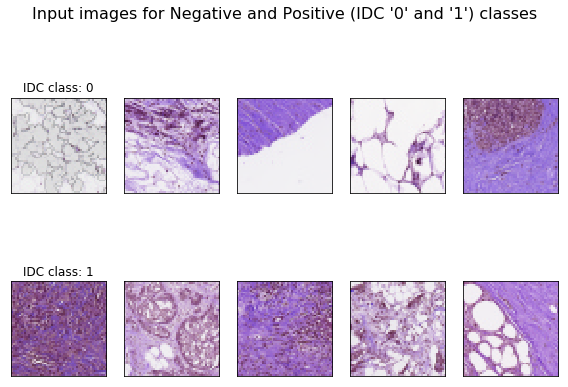

In [12]:
fig, axes = plt.subplots(NUM_CLASSES, NUM_IMAGES_TO_DISPLAY, figsize=(8, 8))
fig.suptitle("Input images for Negative and Positive (IDC '0' and '1') classes", y=0.9, fontsize=16)
axes = axes.ravel() 

for k in range(NUM_CLASSES):
    plot_image_for_category(k, NUM_IMAGES_TO_DISPLAY)
    fig.tight_layout()

#### Data augmentation, Generators 

In [15]:
# defining the data generators
    
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        # shear_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True,
        vertical_flip=True)  
    
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size = (WIDTH, HEIGHT),
        batch_size = BATCH_SIZE,
        class_mode='binary',
        shuffle = True)

validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size = (WIDTH, HEIGHT),
        batch_size = BATCH_SIZE,
        class_mode='binary')


Found 222139 images belonging to 2 classes.
Found 55385 images belonging to 2 classes.


### III. Model 
The model is comprised of a base-model and a top-model: $$Model = base\, model + top\, model$$

###### Base model 

In [16]:
#Load the VGG model

#tb = TensorBoard(log_dir="logs/{}".format(time()))

base_vgg_model = VGG16(weights='imagenet', include_top=False)

<h6> Top model </h6>

In [17]:
# adding a dense layer to the base model

x = base_vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x) 
model = Model(inputs=base_vgg_model.input, outputs=predictions)

### IV. Transfer Learning 

In order to compare the different learning rate schemes we set up our experiments within a transfer learning classification framework. The training has two stages: feature extraction and fine-tuning. 

###### Feature extraction 
1. We start with a base VGG16 model pretrained with ImageNet and freeze all but the final fully-connected layer.
2. The final layer is replaced with a binary classification layer thereby remapping ImageNet classes to IDC classes. This functions as a fixed feature extractor for the IDC dataset.
3. A learning rate range test is performed to find the optimal learning rate for the model in this configuration.
4. We train  for 3 epochs with this learning rate. The weights are used to initialize the fine-tuning stage.

###### Fine-tuning 
1. We unfreeze the last 12 layers (this corresponds to blocks 4 and 5) of the VGG16 model.
2. A learning rate range test is performed to find the LR and CLR bounding values.
3. Train for 10 epochs/30,000 iterations (at 3000 iter./epoch).  

###### Experiments 
We compare the loss profile for each of the three learning rate policies during Fine-tuning. The breakdown for the learning rate over the 30,000 iterations is described in the [Fine-tuning section](#IV-2.-Fine-tuning).

#### IV 1. Feature Extraction
###### Freezing all the layers of the base model 

In [18]:
# freezing all the layers of the base model

def freeze_transfer_learning(verbose=True):
    
    """
    This function freezes all the layers of the base model.
    It is used in the transfer learning stage of training.
    """
    for layer in base_vgg_model.layers:
        layer.trainable = False
  
    #By printing the layers, we can confirm that the base-model 
    #layers are not trainable whereas the top-model layers are.
    if verbose:
        print('\n Printing the base model layers: \n')
        for layer in base_vgg_model.layers:
            print(layer, layer.trainable)
            
        print('\n Printing all the layers of the model: \n')
        for layer in model.layers:
            print(layer, layer.trainable)
        

In [19]:
freeze_transfer_learning()


 Printing the base model layers: 

<keras.engine.topology.InputLayer object at 0x7f8a5eef85f8> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5eef8da0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5eef8be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8a5eef8d68> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5eef2d68> False
<keras.layers.convolutional.Conv2D object at 0x7f8a45682208> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8a5c178ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a46c996a0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a46c99940> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5c248fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8a5c25ccc0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5c05b710> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5c05b9b0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a4648a588> False
<keras.layers.pooling.MaxPo

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

After freezing the base model layers, note that only 526,337 parameters or 3% or the model is trainable.

###### Find the learning rate for feature extraction

The *learning rate range test* is a method to find both a good learning rate (LR) for the model and in cases where the LR is cycled, pick maximum and minimum values. The procedure, outlined by Leslie Smith <a href="#ref1">[1]</a>, is as follows:

Starting from a small value (e.g. $1 \times 10^{-5}$), the LR is gradually increased in mini-batch steps to the point where the loss starts diverging rapidly. We plot the learning rate vs loss, and locate the  point where the loss is a minimum. The region to the right of this corresponds to LRs that are too large.  The region slightly to the left of this point, where the loss is still decreasing, corresponds to LRs that are not too slow. A LR in this left region, which is an order of magnitude less than the LR corresponding to the minimum point, is a good learning rate for the model.    For cases where the LR is cycled between two values, this will set the bound for the maximum LR. The minimum LR is an order of a magnitude smaller.  

The test is implemented in Keras via the [lrate_callback](https://github.com/Meena-Mani/IDC_breast_cancer/blob/master/lrate_callback.py).

In [39]:
# function to find/plot the learning rate using the LRFinder callback

def find_lr(MIN_LR=1e-5, MAX_LR=1e-2, STEPS=3000, 
            EPOCHS=3, CLASS_WEIGHTS={0 : 1, 1 : 2}, 
            beta = 0.99):
    
    lr_finder = LRFinder(min_lr=MIN_LR, 
                         max_lr=MAX_LR, 
                         steps_per_epoch=STEPS, 
                         epochs=EPOCHS,
                         beta = beta)
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=3000,
        epochs=3,
        workers=3,
        callbacks = [lr_finder],
        class_weight = CLASS_WEIGHTS)
    
    lr_finder.plot_loss()
    lr_finder.plot_lr()
   

Epoch 1/3
3000/3000 [==============================] - 504s 168ms/step - loss: 0.6395 - acc: 0.7887
Epoch 2/3
3000/3000 [==============================] - 504s 168ms/step - loss: 0.6129 - acc: 0.8004
Epoch 3/3
3000/3000 [==============================] - 502s 167ms/step - loss: 0.6111 - acc: 0.8053


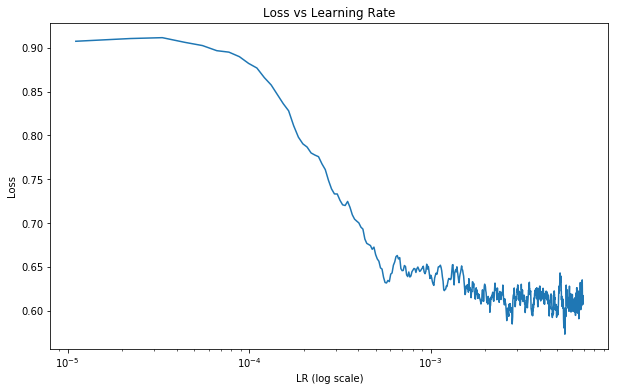

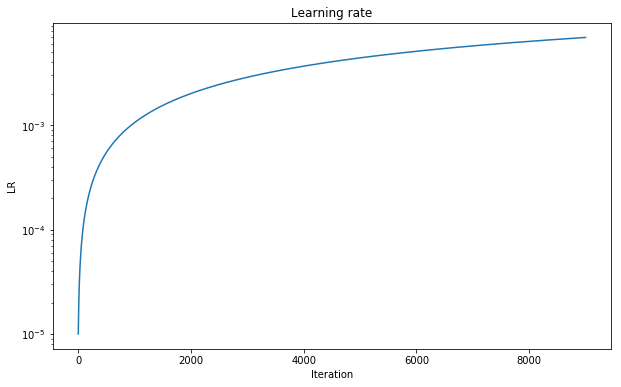

In [32]:
# compile base model and find learning rate

OPTIMIZER = Adam()
model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

find_lr()

From the Loss vs LR plot above, the minimum appears to be in the 0.005 - 0.007 region (at 0.01 the loss function diverges--not shown in this smoothed plot). A LR of 0.002 to the left of the minimum gives us the calibration where the LR is fast and the loss is still decreasing. 

###### Feature extraction -- train for 3 epochs

In [34]:
OPTIMIZER = Adam(lr= 0.002)
model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
if RESUME_TL:
    model.load_weights(TRANSFER_LEARNING_WEIGHTS_FILE)
    print('resume TL')
    

filepath = TRANSFER_LEARNING_WEIGHTS_FILE
print(filepath)
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', verbose=1, save_best_only=False,
                             save_weights_only=False, mode='auto',period=1)


history_tl = model.fit_generator(
        train_generator,
        steps_per_epoch=3000,
        epochs=3,
        workers=4,
        validation_data=validation_generator,
        validation_steps=800,
        callbacks = [checkpoint],
        class_weight = CLASS_WEIGHTS)


 
| epoch |    loss  |    acc |  val_loss|  val_acc  |  
| --- | --- | --- | --- | --- |
| 1 | 0.5809 | 0.8144 | 0.4062  | 0.8213 |
| 2 | 0.5778 | 0.8166 | 0.4009  | 0.8211 |
| 3 | 0.5697 | 0.8187 | 0.3736  | 0.8345 |

#### IV 2. Fine-tuning

In the Fine-tuning stage, we set up three experiments and train each for 10 epochs or 30,000 iterations. The breakdown for the learning rate is:
1. CLR  (triangular mode w/ cycle of 12,000 iterations; restart after 15,000 iterations)
2. 1cycle (29,500 iterations + 500 iter cos anneal)
3. Fixed (the LR remains the same for 30,000 iterations)

The steps leading up to the training step are identical in all three cases. To recap, the pipeline is:
1. Feature extraction
2. Unfreeze the last 12 layers of the model
3. Pick a LR or LR bounding values using the LR range test 
4. Train for 10 epochs/30,000 iterations with SGD+momentum and experimental LR

###### Unfreezing 12 layers of the model

In [20]:
def unfreeze_to_finetune(model, nb_layers=4, verbose=True):
    """Freeze the bottom layers and retrain the top NUM_LAYERS_TO_TRAIN layers.
    """

    for layer in model.layers[:-nb_layers]:
        layer.trainable = False
    for layer in model.layers[-nb_layers:]:
        layer.trainable = True
    
    if verbose:
        for layer in model.layers:
            print(layer, layer.trainable)
    

In [21]:
unfreeze_to_finetune(model, NUM_LAYERS_TO_TRAIN)

<keras.engine.topology.InputLayer object at 0x7f8a5eef85f8> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5eef8da0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5eef8be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8a5eef8d68> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5eef2d68> False
<keras.layers.convolutional.Conv2D object at 0x7f8a45682208> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8a5c178ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a46c996a0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a46c99940> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5c248fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8a5c25ccc0> False
<keras.layers.convolutional.Conv2D object at 0x7f8a5c05b710> True
<keras.layers.convolutional.Conv2D object at 0x7f8a5c05b9b0> True
<keras.layers.convolutional.Conv2D object at 0x7f8a4648a588> True
<keras.layers.pooling.MaxPooling2D object at 0x7f8a5c086d30> True


In [22]:
model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

###### Find the learning rate for fine-tuning
We calibrate the learning rate curve for the new model configuration which now has 12 unfrozen layers. This plot is used to select learning rates for all three experiments.

Epoch 1/3
3000/3000 [==============================] - 734s 245ms/step - loss: 0.5520 - acc: 0.8269
Epoch 2/3
3000/3000 [==============================] - 736s 245ms/step - loss: 0.5073 - acc: 0.8405
Epoch 3/3
3000/3000 [==============================] - 732s 244ms/step - loss: 0.4724 - acc: 0.8535


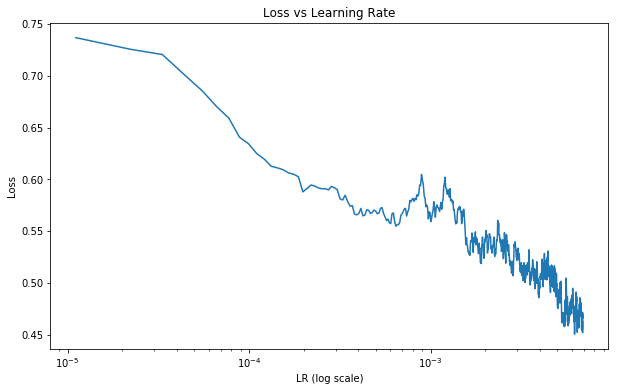

In [40]:
find_lr()

In the higher end of the LR range ($1 \times 10^{-5}$ to $1 \times 10^{-2}$) the Loss did not begin to diverge so we select an LR of 0.005, which is close to the higher end, as the maximum value. For a cyclical LR, the base learning rate is an order of magnitude lower. The value we set is $5 \times 10^{-5}$. We use these bounding values for both the CLR and 1cycle experiments.

##### Experiment 1: Fine-tuning -- CLR

In <a href="#ref1">[1]</a> the author shows via experiments on common benchmark datasets and architectures that with the CLR schedule the training converges faster. Some of his guidelines for using CLR are (i) select LR bands via the LR range test (ii) the stepsize (half a full cycle) should be 2 - 10 times the length of an epoch (iii) the training should stop at the end of a cycle where accuracy is the highest.

We set up the CLR experiment in the following way:  
- LR range: we select 5e-5 to 5e-3. (This performs better than a previous run, with a narrower LR band: 3e-5 to 1e−3). 
- Step size/Cycle length: we set the cycle length of 12,000 iterations (which is four times the length of an epoch and satisfies the guideline). 
- Epochs/Iterations: train for 5 epochs/15,000 iterations, reset the base learning rate and train for another 5 epochs for a total of 30,000 iterations. 

        
The CLR is implemented in Keras via the `CyclicLR callback` (using code available on Github <a href="#ref4">[4]</a> that we modified). 

In [38]:
model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
if RESUME_FT:
    model.load_weights(FINE_TUNING_WEIGHTS_FILE)
else:
    model.load_weights(TRANSFER_LEARNING_WEIGHTS_FILE)

filepath = FINE_TUNING_WEIGHTS_FILE
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', verbose=1,save_best_only=False,
                             save_weights_only=False, mode='auto',period=1)
clr_triangular = CyclicLR(base_lr=5e-5, max_lr=5e-3, fraction=1.,
                          steps_per_epoch=3000, epochs=5, step_size=6000, mode='triangular2') 
callbacks = [checkpoint, clr_triangular]


history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=3000,
        epochs=5,
        workers=4,
        validation_data=validation_generator,
        validation_steps=800,
        callbacks = callbacks,
        class_weight = CLASS_WEIGHTS)


| epoch |    loss  |    acc |  val_loss|  val_acc  |  
| --- | --- | --- | --- | --- |
| 1  |   0.5550 |  0.8261 |    0.4442 |   0.8253 |
| 2  |   0.5085 |  0.8422 |    0.4368 |   0.8149 | 
| 3  |  0.4593  | 0.8561  |   0.2951  |   0.8812 | 
| 4  |  0.4186  | 0.8685  |   0.2890  |   0.8814 |   
| 5  |  0.4049  | 0.8727  |   0.2704  |   0.8877 |


In [ ]:
# reset and repeat the learning rate policy for another 15,000 iterations

clr_triangular._reset()

In [ ]:
history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=3000,
        epochs=5,
        workers=4,
        validation_data=validation_generator,
        validation_steps=800,
        callbacks = callbacks,
        class_weight = CLASS_WEIGHTS)

 | epoch |    loss  |    acc |  val_loss|  val_acc  |  
            | --- | --- | --- | --- | --- |
| 1 |   0.4084 |  0.8716 |  0.3018 |  0.8719 |            
| 2 |  0.4299  | 0.8636  | 0.3343  | 0.8512  |           
| 3 |  0.4176  | 0.8664  | 0.2701  | 0.8854  |         
| 4 |  0.3898  | 0.8757  | 0.2723  | 0.8834  |        
| 5 |  0.3818  | 0.8781  | 0.3197  | 0.8589  |

In [29]:
def plot_learning_rate(clr_triangular):
    
    plt.xlabel('Training Iterations')
    plt.ylabel('Learning Rate')
    plt.title("Cyclical 'triangular2' learning rate (reset at 15000 iterations)")
    plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr']);

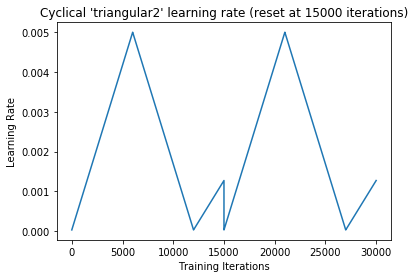

In [30]:
plot_learning_rate(clr_triangular)

In [26]:
def plot_loss(loss,  acc,  val_loss,  val_acc):
    
    def _nan_reindex(a):
        return a[~np.isnan(a)]
        
    x = np.arange(10)
    x = x[~np.isnan(acc)] 
    acc =      _nan_reindex(acc)
    val_acc =  _nan_reindex(val_acc)
    loss =     _nan_reindex(loss)
    val_loss = _nan_reindex(val_loss)
    
    loss_list = [loss, val_loss]
    acc_list =  [acc, val_acc]
    
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,5))
    plt.style.use('ggplot')

    colors = ['limegreen', 'magenta']
    linestyles =['-','--'] 
    legend_list = ['train', 'val']


    for i, color, linestyle in zip(range(2), colors, linestyles):
        ax[0].plot(x, loss_list[i], color = color, linestyle=linestyle)
        ax[1].plot(x, acc_list[i], color = color, linestyle=linestyle)

    ax[0].set_title('Loss, 30 iterations')
    ax[1].set_title('Accuracy, 30 iterations')

    plt.ylim([0.,1.])
    plt.xticks(range(10), range(1,11))
    fig.text(0.5, 0.04, 'epochs', ha='center', va='center')
    plt.legend(legend_list, bbox_to_anchor=(1.05, 0), loc='lower left');

In [31]:
# data for plotting loss

clr_loss = np.array([0.5550, 0.5085, 0.4593, 0.4186, 0.4049, 0.4084,  0.4299, 0.4176, 0.3898, 0.3818]) 
clr_acc = np.array([0.8261, 0.8422, 0.8561,  0.8685, 0.8727, 0.8716, 0.8636, 0.8664, 0.8757, 0.8781])  
clr_val_loss = np.array([0.4442, 0.4368, 0.2951, 0.2890, 0.2704, 0.3018, 0.3343, 0.2701, 0.2723, 0.3197])  
clr_val_acc = np.array([0.8253, 0.8149, 0.8812, 0.8814, 0.8877, 0.8719, 0.8512, 0.8854, 0.8834, 0.8589])

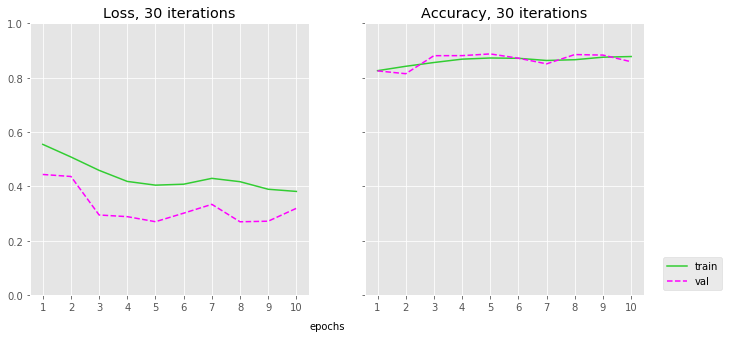

In [32]:
plot_loss(clr_loss,  clr_acc,  clr_val_loss,  clr_val_acc)

During the first 15,000 iterations the loss and accuracy profile was very encouraging approaching 89% validation accuracy in Epoch 5. This was also, as we shall see, better than the '1cycle' at Epoch 5 or any other experiment we had done. The sudden reset at the 15,000 iteration mark however, appears to have adversely affected the training. The loss was able to get back to its former low levels again only at the 24,000 iteration mark. The guideline from the paper <a href="#ref1">[1 p. 3]</a> was to stop training at the end of a cycle when the accuracy was higher and not somewhere in between as was the case here.

The paper gives other guidelines but
the drawback, as I see it, with the CLR is that it will take many experiments to find a cycle schedule that optimizes the training.

##### Experiment 2: Fine-tuning -- 1cycle

The *1cycle* learning rate is a special case of the *CLR* where only one cycle is used followed by cosine annealing to decrease the LR in the  final iterations <a href="#ref2">[2, p.7]</a>. The *1cycle* policy is used to reach super-convergence, a state where the  test loss and accuracy quickly reaching optimal values and thereater remain constant.    
This policy is also implemented via the `CyclicLR callback` function which we have modified to include cosine annealing in the final iterations.  We compute the cycle with the following parameters:

- `base_lr`: initial learning rate, lower boundary of the cycle.
- `max_lr`: upper bound of the cycle -- this as well as the `step-size` is much larger for the 1cycle 
- `steps_per_epoch`: # iterations in an epoch. With this we can calculate total iterations (= steps_per_epoch x epochs). 
- `fraction`: the percentage of total iterations used for one full cycle. For the remainder of the iterations, the LR is reduced further from the base_lr to a value much lower via cosine annealing.
- `step_size`: # iterations in a half-cycle (step_size x 2 = # iterations in a full cycle)


In [ ]:
if RESUME_FT:
    model.load_weights(FINE_TUNING_WEIGHTS_FILE)
else:
    model.load_weights(TRANSFER_LEARNING_WEIGHTS_FILE)

filepath = FINE_TUNING_WEIGHTS_FILE
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', verbose=1,save_best_only=False,
                             save_weights_only=False, mode='auto',period=1)
one_cycle_clr = CyclicLR(base_lr=5e-5, max_lr=5e-3, fraction=0.97,
                 steps_per_epoch=3000, epochs=10, step_size=14550, mode='triangular')
callbacks = [checkpoint, one_cycle_clr]


history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=3000,
        epochs=10,
        workers=4,
        validation_data=validation_generator,
        validation_steps=800,
        callbacks = callbacks,
        class_weight = CLASS_WEIGHTS)

| epoch |    loss  |    acc |  val_loss|  val_acc  |  
            | --- | --- | --- | --- | --- |
| 1 | 0.5555 |  0.8259 |  0.3761  | 0.8467  |                    
| 2 | 0.5048 |  0.8444 |  0.3374  | 0.8554  |                       
| 3 | 0.4814 |  0.8498 |  0.4482  | 0.8038  |         
| 4 | 0.4625 |  0.8553 |  0.3631  | 0.8444  |            
| 5 |    -    |   -    |    -     |   -     |
| 6 | 0.4312 |  0.8639 |  0.3165  | 0.8650  |         
| 7 | 0.4125 |  0.8691 |  0.2673  | 0.8863  |            
| 8 | 0.3934 |  0.8741 |  0.3057  | 0.8672  |          
| 9 | 0.3802 |  0.8796 |  0.2603  | 0.8898  |                 
| 10| 0.3688 |  0.8828 |  0.2639  | 0.8871  |

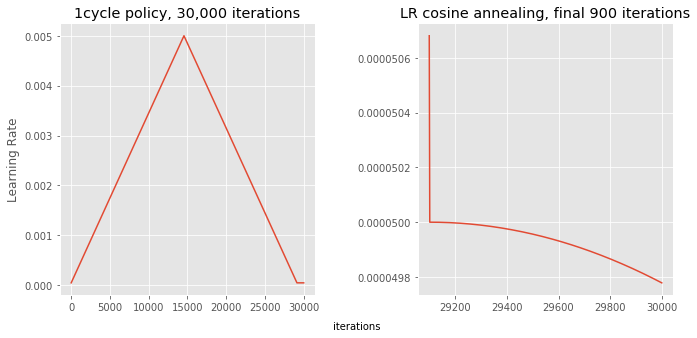

In [25]:
fig, ax = plt.subplots(1, 2,  figsize=(11,5))
fig.subplots_adjust(wspace=0.4)
plt.style.use('ggplot')

ax[0].plot(one_cycle_clr.history['iterations'], one_cycle_clr.history['lr'])
ax[1].plot(one_cycle_clr.history['iterations'][-902:], one_cycle_clr.history['lr'][-902:])

ax[0].set_title('1cycle policy, 30,000 iterations')
ax[1].set_title('LR cosine annealing, final 900 iterations')  
ax[0].set_ylabel('Learning Rate')
fig.text(0.5, 0.04, 'iterations', ha='center', va='center');

In [27]:
# data for plotting loss

oc_loss = np.array([0.5555, 0.5048, 0.4814, 0.4625, np.nan, 0.4312, 0.4125, 0.3934, 0.3802, 0.3688])
oc_acc = np.array([0.8259,  0.8444,  0.8498, 0.8553, np.nan, 0.8639,  0.8691, 0.8741, 0.8796, 0.8828])
oc_val_loss = np.array([0.3761, 0.3374, 0.4482, 0.3631, np.nan, 0.3165, 0.2673, 0.3057, 0.2603, 0.2639])
oc_val_acc = np.array([0.8467, 0.8554, 0.8038, 0.8444, np.nan, 0.8650, 0.8863, 0.8672, 0.8898, 0.8871])

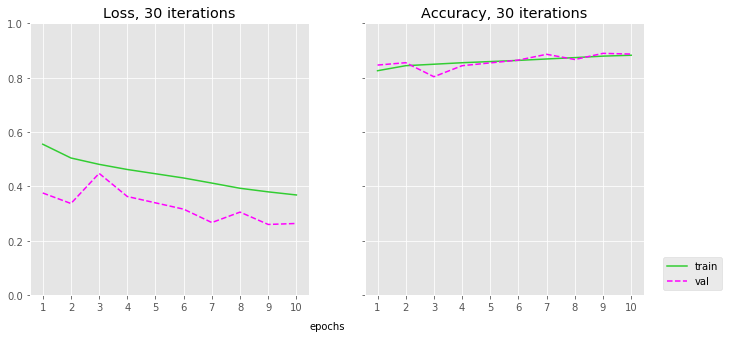

In [29]:
plot_loss(oc_loss,  oc_acc,  oc_val_loss,  oc_val_acc)

##### Experiment 3: Fine-tuning -- Fixed

We compare the cyclical learning rate schedules (Experiments 1 & 2) with a policy where the LR is fixed. Once again we calibrate the LR from the [LR range test](#Find-the-learning-rate-for-fine-tuning) and select a value of $3 \times 10^{-4}$.

In [22]:
model.compile(optimizer=SGD(lr=0.0003, momentum=0.9), 
                loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
if RESUME_FT:
    model.load_weights(FINE_TUNING_WEIGHTS_FILE)
    print('loading fine-tuning weights')
else:
    model.load_weights(TRANSFER_LEARNING_WEIGHTS_FILE)

  
filepath = FINE_TUNING_WEIGHTS_FILE
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', verbose=1,save_best_only=False,
                             save_weights_only=False, mode='auto',period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)
callbacks = [checkpoint, reduce_lr]


history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=3000,
        epochs=10,
        workers=4,
        validation_data=validation_generator,
        validation_steps=800,
        callbacks = callbacks,
        class_weight = CLASS_WEIGHTS)

| epoch |    loss  |    acc |  val_loss|  val_acc  |
| --- | --- | --- | --- | --- |
| 1 | 0.5400 |  0.8292 | 0.3421 |  0.8622 |     
| 2 | 0.4685 |  0.8510 | 0.2919 |  0.8796 |       
| 3 | 0.4410 |  0.8595 | 0.2971 |  0.8736 |         
| 4 | 0.4322 | 0.8620 | 0.2838 |  0.8807  |             
|5 | 0.4213 | 0.8647 | 0.2860 |  0.8820 |          
| 6 | 0.4101 | 0.8667 | 0.2823 |  0.8844 |           
| 7 | 0.4073 | 0.8710 | 0.2781 |  0.8807  |           
|8 | 0.4038 | 0.8703 | 0.2657 |  0.8875  |             
| 9 | 0.3939 |    | 0.2879 |    |                
|10| 0.3906 | 0.8758 | 0.3019 |  0.8712  |

In [24]:
# data for plotting loss

f_loss = np.array([0.5400, 0.4685, 0.4410, 0.4322, 0.4213, 0.4101, 0.4073, 0.4038, 0.3939, 0.3906])
f_acc = np.array([0.8292, 0.8510, 0.8595, 0.8620, 0.8647, 0.8667, 0.8710, 0.8703, np.nan, 0.8758 ])
f_val_loss = np.array([0.3421, 0.2919, 0.2971, 0.2838, 0.2860, 0.2823, 0.2781, 0.2657, 0.2879, 0.3019])
f_val_acc = np.array([0.8622, 0.8796, 0.8736, 0.8807, 0.8820, 0.8844,0.8807,0.8875, np.nan, 0.8712])

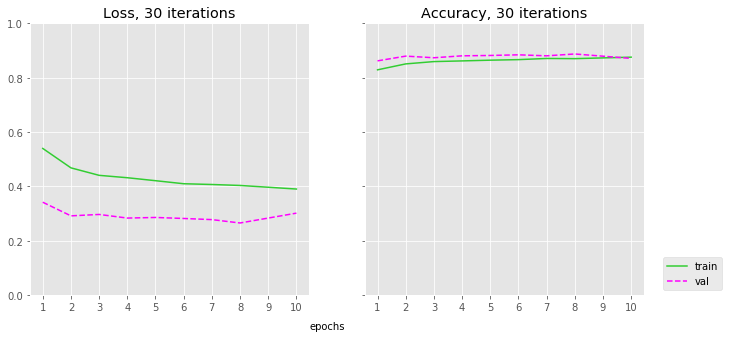

In [30]:
plot_loss(f_loss, f_acc, f_val_loss, f_val_acc)

At the 30,000 iteration mark, the accuracy was the lowest of the three experiments but only by a very small percentage. We also see that the accuracy is markedly better than  other fixed LR experiments where a default  used with  Adam/SGD was applied. We can conclude that regardless of the policy (cyclical, 1cycle, fixed), by using an LR selected via the LR calibration curve we can train a model faster.

### V. Results and Discussion

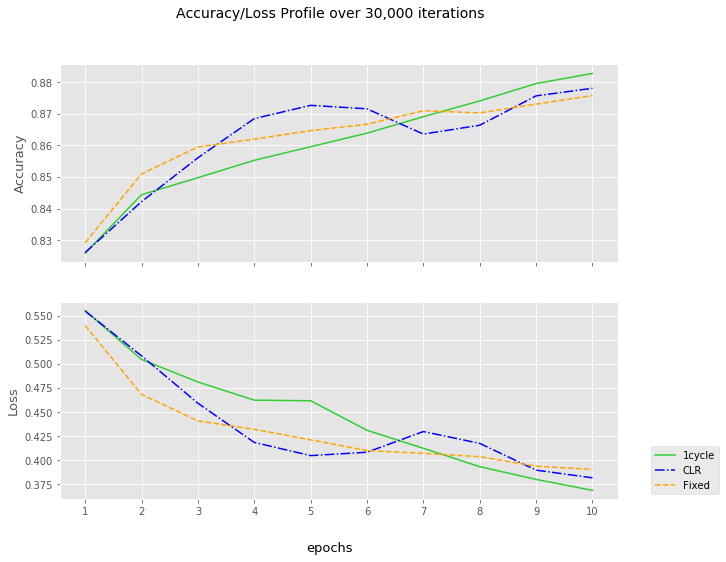

In [31]:
oc_loss = np.array([0.5555, 0.5048, 0.4814, 0.4625, 0.4619, 0.4312, 0.4125, 0.3934, 0.3802, 0.3688])
oc_acc = np.array([0.8259,  0.8444,  0.8498, 0.8553, 0.8596, 0.8639,  0.8691, 0.8741, 0.8796, 0.8828])
clr_loss = np.array([0.5550, 0.5085, 0.4593, 0.4186, 0.4049, 0.4084,  0.4299, 0.4176, 0.3898, 0.3818]) 
clr_acc = np.array([0.8261, 0.8422, 0.8561,  0.8685, 0.8727, 0.8716, 0.8636, 0.8664, 0.8757, 0.8781])  
f_loss = np.array([0.5400, 0.4685, 0.4410, 0.4322, 0.4213, 0.4101, 0.4073, 0.4038, 0.3939, 0.3906])
f_acc = np.array([0.8292, 0.8510, 0.8595, 0.8620, 0.8647, 0.8667, 0.8710, 0.8703, 0.8731, 0.8758 ])

x = np.arange(10)
acc_list = [oc_acc,  clr_acc,  f_acc  ]
loss_list = [oc_loss,  clr_loss,  f_loss]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,8))
plt.style.use('ggplot')

colors = ['limegreen',  'blue',  'orange']
linestyles =['-','-.', '--' ] 
legend_list = ['1cycle', 'CLR', 'Fixed']


for i, color, linestyle in zip(range(3), colors, linestyles):
    ax[0].plot(x, acc_list[i], color = color, linestyle=linestyle)
    ax[1].plot(x, loss_list[i], color = color, linestyle=linestyle)


ax[0].set_ylabel('Accuracy', fontsize=13)
ax[1].set_ylabel('Loss', fontsize=13)
plt.xticks(range(10), range(1,11))
fig.text(0.5, 0.04, 'epochs', ha='center', va='center', fontsize=13)
plt.suptitle('Accuracy/Loss Profile over 30,000 iterations', fontsize=14)
plt.legend(legend_list, bbox_to_anchor=(1.05, 0), loc='lower left');


(This section is a draft -- need to finish)

The plot above shows a direct comparison of the three experiments over 10 epochs/30,000 iterations. 

1cycle:   
At the 30000 iteration mark, the '1cycle' policy has the highest accuracy and lowest loss while the 'fixed' LR has the lowest accuracy. This supports the findings of Leslie Smith. In terms of both raw accuracy and as a percentage (of the fixed), the accuracy numbers are close, however, and there is less than a 1% spread. Furthermore, these are the results from a single set of runs, and the experiment needs to be repeated to draw conclusions.

From other experiments (we did 25+ training runs with a varying set of baseline parameters) we observe the following:

CLR:   
In addition to this experiment we did 5-6 additional experiments with different CLR cycle frequencies and policies (triangular/triangular2). These experiments gave varying results and it was difficult to determine the exact cycle that would be optimal. In some cases such as this experiment,  the results were promising for 5 or 10 epochs but not over an extended training time line.


Fixed:    
The accuracy when the LR was constant, was the lowest of the three experiments but only by a small amount. The LR rate was selected via the LR calibration curve and we observed a marked difference when the LR range test was used and when the LR was randomly selected.

LR range test:  
One observation that was clear from 25+ tests is that with an LR selected via the learning rate range test, we can train faster. Compare going from  an accuracy of 80-82% to 88-89% in 30,000 iterations to a situation where the accuracy remains at 85-86% for most of that training interval. In the first case, the LR was selected via the LR test; in the second case the initial  LR was a default value that is commonly used for Adam/SGD/network architecture.  

### VI. References and Further Reading

<a name="ref1"></a>[1] [Leslie N. Smith. (2016). Cyclical Learning Rates for Training Neural Networks,](https://arxiv.org/pdf/1506.01186.pdf)  
<a name="ref2"></a>[2] [Leslie N. Smith. (2018). A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay.  CoRR abs/1803.09820 (2018)](https://arxiv.org/abs/1803.09820)  
<a name="ref3"></a>[3] [Jeremy Howard and others. (2018) fastai. On Github](https://github.com/fastai/fastai)     
<a name="ref4"></a>[4] [Brad Kentsler. (2018) CLR. On Github](https://github.com/bckenstler/CLR)

**Author:  Meena Mani  
Email:   meenas.mailbag@gmail.com   
Twitter: @meena_uvaca  **  